## データの取り込み

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style="white")
pd.set_option('display.max_columns', 150)

df_train_master = pd.read_csv("sales_predict_train.csv")
df_submit_master = pd.read_csv("sales_predict_test.csv")
display(df_train_master.head())
display(df_submit_master.head())

,date,date_block_num,item_id,item_category_id,item_cnt_day
0,02.01.2013,0,22154,37,1.0
1,22.01.2013,0,4907,23,1.0
2,11.01.2013,0,4907,23,1.0
3,08.01.2013,0,2258,28,1.0
4,23.01.2013,0,2258,28,1.0


,item_id,date_block_num
0,0,33
1,1,33
2,2,33
3,3,33
4,4,33


## データ探索(EDA)とデータ集計処理

In [51]:
#学習データのサマリ
display(df_train_master.info())
display(df_train_master.describe())

#item_cnt_dayにマイナスがある

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2882335 entries, 0 to 2882334
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   item_id           int64  
 3   item_category_id  int64  
 4   item_cnt_day      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 110.0+ MB


None

,date_block_num,item_id,item_category_id,item_cnt_day
count,2.882335e+06,2.882335e+06,2.882335e+06,2.882335e+06
mean,1.422773e+01,1.018604e+04,3.995896e+01,1.241060e+00
std,9.166123e+00,6.326743e+03,1.707675e+01,2.283184e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,6.000000e+00,4.466000e+03,2.800000e+01,1.000000e+00
50%,1.300000e+01,9.250000e+03,4.000000e+01,1.000000e+00
75%,2.200000e+01,1.569300e+04,5.500000e+01,1.000000e+00
max,3.200000e+01,2.216900e+04,8.300000e+01,1.000000e+03


In [52]:
#予測用データ
display(df_submit_master.info())
display(df_submit_master.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   item_id         21332 non-null  int64
 1   date_block_num  21332 non-null  int64
dtypes: int64(2)
memory usage: 333.4 KB


None

,item_id,date_block_num
count,21332.000000,21332.0
mean,11072.501453,33.0
std,6371.206639,0.0
min,0.000000,33.0
25%,5539.750000,33.0
50%,11061.500000,33.0
75%,16603.250000,33.0
max,22169.000000,33.0


In [53]:
#item_cnt_dayがマイナスのもの
display(df_train_master[df_train_master["item_cnt_day"]<0])

#返品数が多い商品＋月の把握
df_train_master[df_train_master["item_cnt_day"]<0].groupby(["item_id","date_block_num"],as_index=False).sum().sort_values("item_cnt_day").head(10)[["item_id","date_block_num","item_cnt_day"]]

#特別返品が多い商品や月があるわけではない様子

,date,date_block_num,item_id,item_category_id,item_cnt_day
312,07.01.2013,0,19679,41,-1.0
633,10.01.2013,0,2252,30,-1.0
676,13.01.2013,0,21395,37,-1.0
957,28.01.2013,0,2308,30,-1.0
2063,05.01.2013,0,1836,19,-1.0
...,...,...,...,...,...
2880714,07.09.2015,32,14400,37,-1.0
2881391,28.09.2015,32,2780,20,-1.0
2881491,19.09.2015,32,1847,19,-1.0
2881548,23.09.2015,32,5902,20,-1.0


,item_id,date_block_num,item_cnt_day
694,2331,13,-24.0
3379,8023,10,-22.0
692,2331,11,-19.0
5997,20949,18,-17.0
1431,3732,9,-14.0
357,1590,0,-13.0
3578,9242,21,-10.0
1453,3734,10,-10.0
2134,5228,2,-9.0
2133,5228,1,-8.0


In [54]:
#item毎にitem_categoryが1つであることを確認
df_train_master.groupby("item_id").nunique("item_category_id").sort_values("item_category_id",ascending=False)["item_category_id"]

item_id
0        1
14769    1
14767    1
14764    1
14763    1
        ..
7395     1
7394     1
7393     1
7392     1
22169    1
Name: item_category_id, Length: 21332, dtype: int64

In [55]:
#item_idごとに月次売上個数を集計(date_block_numがあるため、dateは今回使わない)
df_train = df_train_master.drop("date", axis=1).groupby(["item_id","date_block_num","item_category_id"],as_index=False).sum()
df_train.head()

,item_id,date_block_num,item_category_id,item_cnt_day
0,0,20,40,1.0
1,1,15,76,2.0
2,1,18,76,1.0
3,1,19,76,1.0
4,1,20,76,1.0


<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

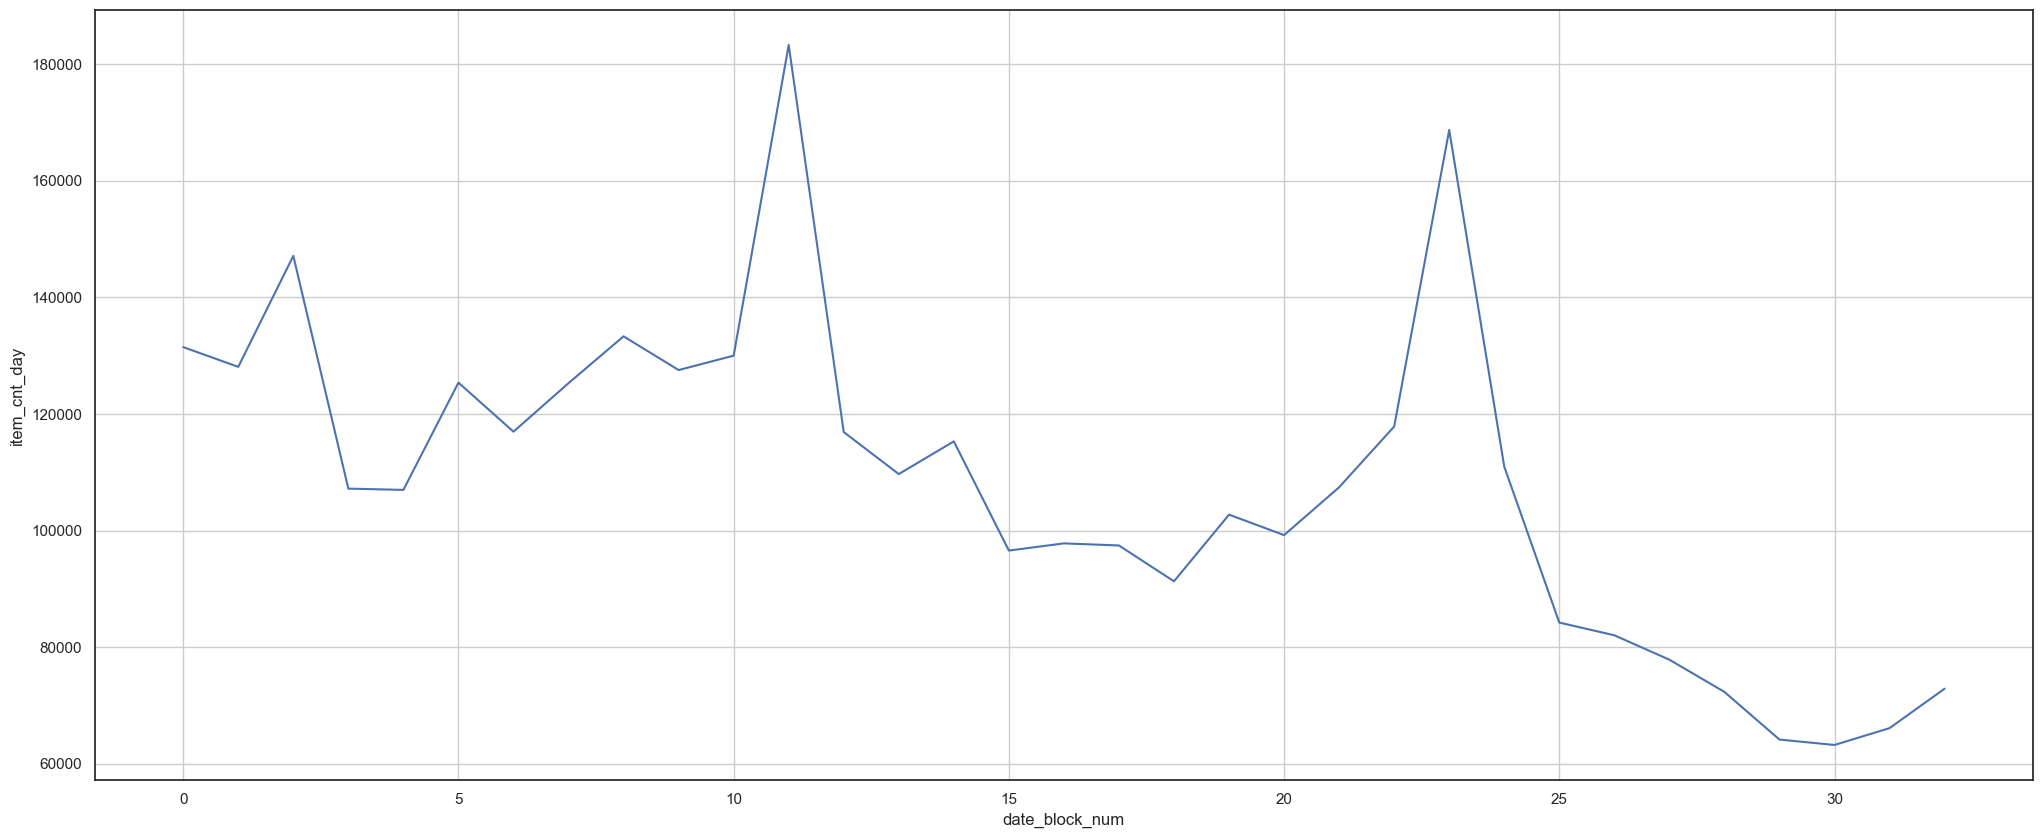

In [56]:
#全体の販売個数推移
plt.figure(figsize=(25,10))
plt.grid(True)
graph_df = df_train.groupby("date_block_num", as_index=False).sum()
sns.lineplot(data=graph_df, x="date_block_num", y="item_cnt_day")

#全体的に販売個数は減少傾向
#1年ごとに周期性があり、date_block_numが11と23の月(12月)は売上が上がる傾向があるため注意が必要
#今回予測するのは10月は1年前よりも1ヶ月前のデータとの方が相関が強そう

<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

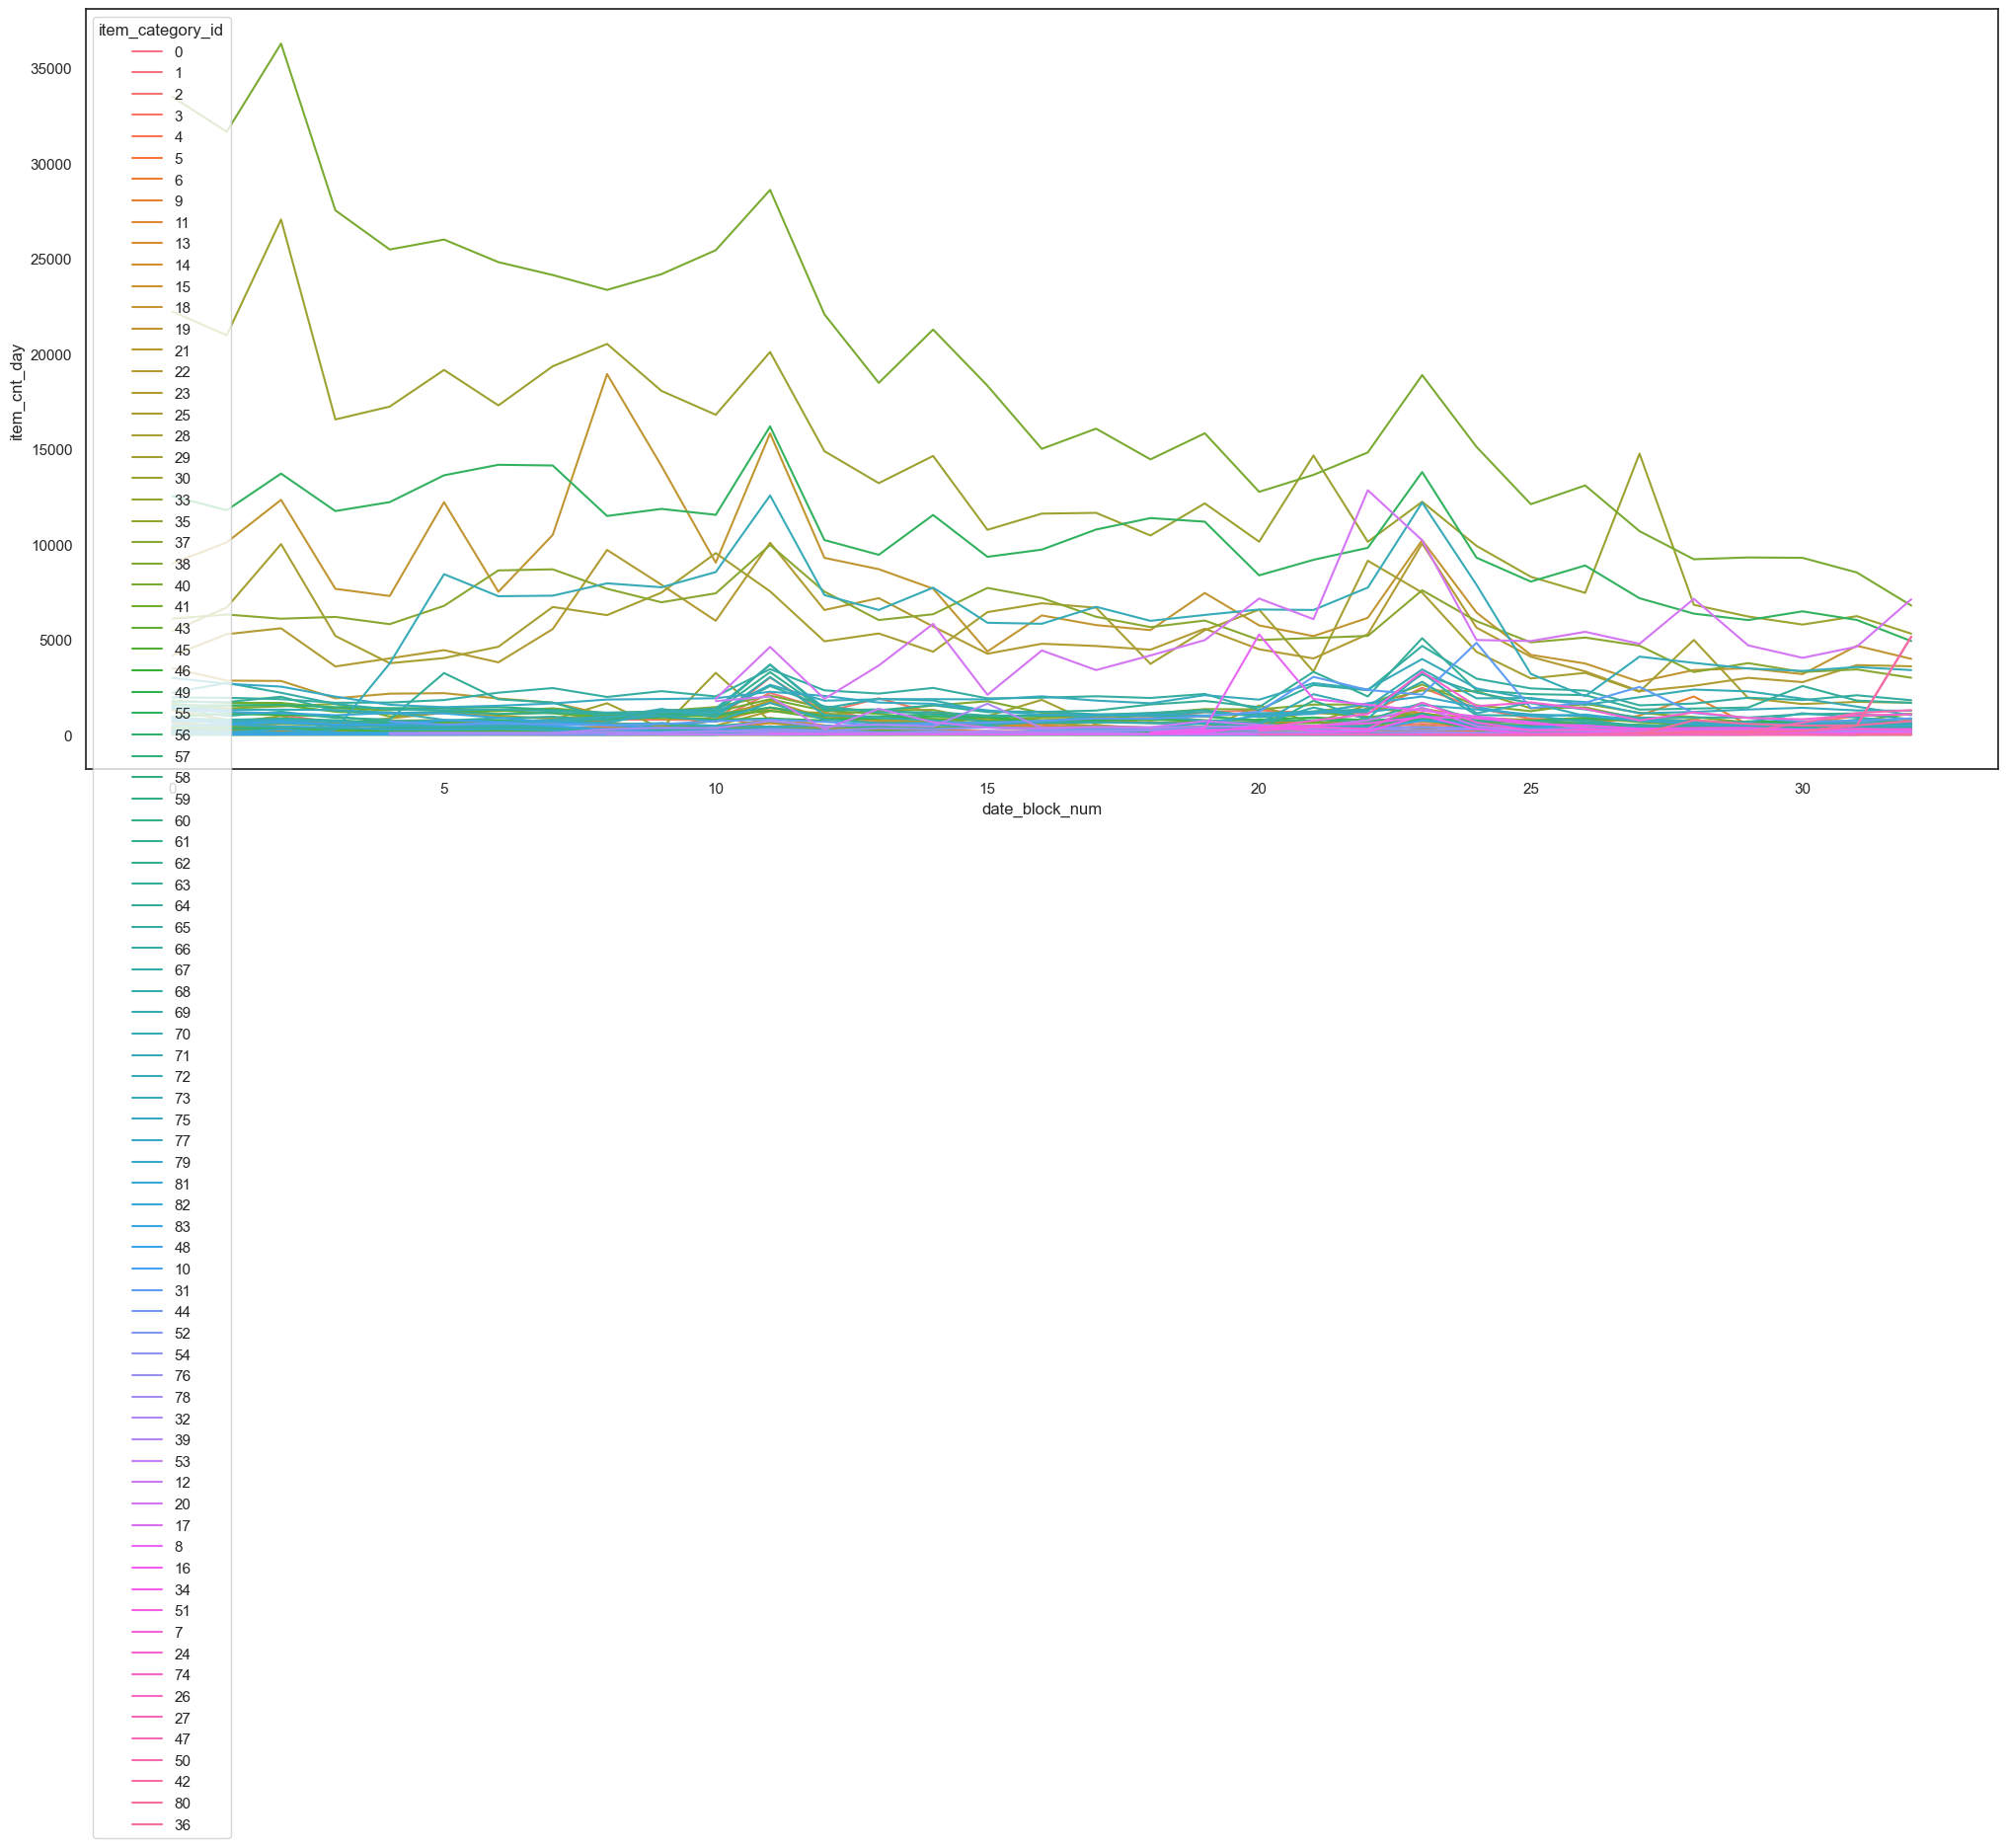

In [57]:
#item_categoryごとの販売個数推移
plt.figure(figsize=(25, 10))
df_graph = df_train.groupby(["date_block_num","item_category_id"],as_index=False).sum()
df_graph["item_category_id"] = df_graph["item_category_id"].astype("str")
sns.lineplot(data=df_graph, x="date_block_num", y="item_cnt_day", hue="item_category_id")

#どのカテゴリーも似たような動きをしている

## 機械学習の前処理

In [58]:
#まずはアイテムごとの月次販売個数のみを使用して予測してみる
df_train_naive=df_train.groupby(["date_block_num","item_id"],as_index=False).sum()
#pivotに変換し、空欄は0を挿入(機械学習にかけるため、縦持ちデータを横持ちデータに変換)
df_train_naive=pd.pivot_table(df_train_naive,index="item_id",columns="date_block_num",values="item_cnt_day")
df_train_naive=df_train_naive.fillna(0)
df_train_naive=df_train_naive.reset_index()
df_train_naive

date_block_num,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21327,22165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21328,22166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,24.0,32.0,25.0,24.0,21.0,13.0,10.0,15.0,12.0,13.0,13.0,12.0,16.0,11.0,7.0,8.0,12.0,4.0,8.0,10.0,8.0,11.0,5.0
21329,22167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,146.0,96.0,83.0,66.0,57.0,47.0,59.0,41.0,56.0,47.0,47.0,39.0,49.0,49.0,40.0,33.0,46.0,40.0,38.0,31.0,33.0,34.0,29.0,21.0
21330,22168,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
#学習用と検証用の特徴量作成
#テストデータは予測する月の前年同月(date_block_num=21)、学習データはテストデータ以前のもののみ使用
#特徴量は先月(短期の自己相関)、前年同月の販売個数(周期変動)、先月の前年同月比(長期トレンド要素)、先々月と先月の比(短期トレンド要素)　※外因性要素は今回はなし
X_train=df_train_naive[["item_id",19,8,7,18]]
X_train.columns=["item_id","1M","1Y","1Y+1M","2M"]
X_train["long_trend"]=(X_train["1M"]+0.00001)/(X_train["1Y+1M"]+0.00001) #少ない数を足して分母が0にならないよう調整
X_train["short_trend"]=(X_train["1M"]+0.00001)/(X_train["2M"]+0.00001)
X_train=X_train.drop(["item_id","1Y+1M","2M"],axis=1)
y_train=df_train_naive[20]

X_test=df_train_naive[["item_id",20,9,8,19]]
X_test.columns=["item_id","1M","1Y","1Y+1M","2M"]
X_test["long_trend"]=(X_test["1M"]+0.00001)/(X_test["1Y+1M"]+0.00001)
X_test["short_trend"]=(X_test["1M"]+0.00001)/(X_test["2M"]+0.00001)
X_test=X_test.drop(["item_id","1Y+1M","2M"],axis=1)
y_test=df_train_naive[21]

display(X_train.info())
display(X_test.info())
display(X_train.head())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   1M           21332 non-null  float64
 1   1Y           21332 non-null  float64
 2   long_trend   21332 non-null  float64
 3   short_trend  21332 non-null  float64
dtypes: float64(4)
memory usage: 666.8 KB


/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/1479400573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["long_trend"]=(X_train["1M"]+0.00001)/(X_train["1Y+1M"]+0.00001) #少ない数を足して分母が0にならないよう調整
/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/1479400573.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["short_trend"]=(X_train["1M"]+0.00001)/(X_train["2M"]+0.00001)
/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/1479400573.py:13: Settin

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   1M           21332 non-null  float64
 1   1Y           21332 non-null  float64
 2   long_trend   21332 non-null  float64
 3   short_trend  21332 non-null  float64
dtypes: float64(4)
memory usage: 666.8 KB


None

,1M,1Y,long_trend,short_trend
0,0.0,0.0,1.0,1.0
1,1.0,0.0,100001.0,1.0
2,1.0,0.0,100001.0,100001.0
3,1.0,0.0,100001.0,1.0
4,0.0,0.0,1.0,1.0


,1M,1Y,long_trend,short_trend
0,1.0,0.0,100001.0,100001.00000
1,1.0,0.0,100001.0,1.00000
2,0.0,0.0,1.0,0.00001
3,0.0,0.0,1.0,0.00001
4,1.0,0.0,100001.0,100001.00000


## 予測と評価

In [60]:
#重回帰分析(sklearn)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

#スコア算出
from sklearn.metrics import r2_score,mean_squared_error
print("r2=", r2_score(y_true=y_test, y_pred=y_pred))
print("RMSE=", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
#回帰係数算出
pd.DataFrame(lr.coef_, index=X_train.columns)

r2= 0.7921122368911838
RMSE= 24.79486762094696


,0
1M,0.995043
1Y,0.012381
long_trend,-0.000004
short_trend,-0.000001


In [61]:
#決定木分析
from sklearn import tree
clf=tree.DecisionTreeClassifier(max_depth=30,random_state=1)
clf=clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

#スコア算出
from sklearn.metrics import r2_score,mean_squared_error
print("r2=",r2_score(y_true=y_test,y_pred=y_pred))
print("RMSE=",np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred)))

#重回帰分析を採用

r2= 0.7746117973040854
RMSE= 25.81742482005169


In [62]:
#ベースラインモデル
y_pred=X_test["1M"]
print("r2=",r2_score(y_true=y_test,y_pred=y_pred))
print("RMSE=",np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred)))

r2= 0.5585724386189972
RMSE= 36.13075640257742


In [63]:
#予測用データ作成+予測
X_submit = df_train_naive[["item_id",32,21,20,31]]
X_submit.columns=["item_id","1M","1Y","1Y+1M","2M"]
X_submit["long_trend"]=(X_submit["1M"]+0.00001)/(X_submit["1Y+1M"]+0.00001)
X_submit["short_trend"]=(X_submit["1M"]+0.00001)/(X_submit["2M"]+0.00001)
X_submit=X_submit.drop(["item_id","1Y+1M","2M"],axis=1)
y_pred = lr.predict(X_submit)
pred_df = pd.DataFrame(df_train_naive["item_id"])
pred_df["y"] = y_pred

#サブミットデータ作成
df_submit = pd.merge(df_submit_master, pred_df, on="item_id", how="left")
df_submit = df_submit[["item_id", "y"]]
df_submit.to_csv("sales_predict_submit.csv", index=False)
df_submit
#最終スコアはRMSE=20.62

/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/3776194360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit["long_trend"]=(X_submit["1M"]+0.00001)/(X_submit["1Y+1M"]+0.00001)
/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/3776194360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit["short_trend"]=(X_submit["1M"]+0.00001)/(X_submit["2M"]+0.00001)


,item_id,y
0,0,1.052123
1,1,1.064504
2,2,1.052119
3,3,1.052119
4,4,1.052123
...,...,...
21327,22165,1.052119
21328,22166,6.175911
21329,22167,22.554700
21330,22168,1.052119


## おまけ(item_category_idをtarget encodingして特徴量に追加する)

In [64]:
#item_category_id毎に各月の売上数を集計
df_category=df_train_master
df_category=df_category.groupby(["item_category_id","date_block_num"],as_index=False).sum()[["item_category_id","date_block_num","item_cnt_day"]]
df_category=pd.pivot_table(df_category,index="item_category_id",columns="date_block_num",values="item_cnt_day")
df_category=df_category.fillna(0)
df_category=df_category.reset_index()
df_category

date_block_num,item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,790.0,759.0,2192.0,1339.0,742.0,645.0,508.0,444.0,487.0,351.0,342.0,355.0,372.0,357.0,573.0,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0
3,3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,391.0,744.0,3004.0,1180.0,1909.0,1140.0,669.0,716.0,855.0,873.0,1182.0,1282.0,1123.0,1127.0,2459.0,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0
4,4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,89.0,83.0,112.0,96.0,46.0,58.0,35.0,43.0,54.0,46.0,35.0,21.0,27.0,9.0,20.0,10.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,145.0,128.0,275.0,94.0,83.0,64.0,64.0,67.0,52.0,57.0,49.0,92.0,61.0,69.0,77.0,142.0,167.0,206.0,323.0,620.0,986.0,1088.0,1651.0,2002.0,1454.0,962.0,1056.0,744.0,558.0,499.0,497.0,486.0,491.0
80,80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,147.0,117.0,195.0,483.0,5149.0
81,81,177.0,111.0,106.0,115.0,113.0,75.0,98.0,48.0,32.0,26.0,19.0,9.0,10.0,8.0,7.0,2.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82,82,1374.0,1192.0,1125.0,1021.0,1139.0,1114.0,889.0,657.0,506.0,336.0,336.0,178.0,96.0,107.0,114.0,95.0,80.0,26.0,1.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#カテゴリーマスターテーブルの作成
category_master=df_train.groupby(["item_id","item_category_id"],as_index=False).count()[["item_id","item_category_id"]]
#df_train_naiveにcaetgory_idを追加
df_train_add_category=pd.merge(df_train_naive,category_master,on="item_id",how="left")
df_train_add_category

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,item_category_id
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21327,22165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31
21328,22166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,24.0,32.0,25.0,24.0,21.0,13.0,10.0,15.0,12.0,13.0,13.0,12.0,16.0,11.0,7.0,8.0,12.0,4.0,8.0,10.0,8.0,11.0,5.0,54
21329,22167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,146.0,96.0,83.0,66.0,57.0,47.0,59.0,41.0,56.0,47.0,47.0,39.0,49.0,49.0,40.0,33.0,46.0,40.0,38.0,31.0,33.0,34.0,29.0,21.0,49
21330,22168,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62


In [66]:
#学習データ、テストデータ作成

X_train2=df_train_add_category[["item_id",19,8,7,18,"item_category_id"]]
X_train2.columns=["item_id","1M","1Y","1Y+1M","2M","item_category_id"]
X_train2["long_trend"]=(X_train2["1M"]+0.00001)/(X_train2["1Y+1M"]+0.00001)
X_train2["short_trend"]=(X_train2["1M"]+0.00001)/(X_train2["2M"]+0.00001)
#カテゴリーの前年同月の販売個数をcategory_scoreとして追加
X_train2=pd.merge(X_train2,df_category[["item_category_id",8]],on="item_category_id",how="left")
X_train2=X_train2.rename(columns={8: "category_score"})
X_train2=X_train2.drop(["item_id","1Y+1M","2M","item_category_id"],axis=1)
y_train2=df_train_add_category[20]

X_test2=df_train_add_category[["item_id",20,9,8,19,"item_category_id"]]
X_test2.columns=["item_id","1M","1Y","1Y+1M","2M","item_category_id"]
X_test2["long_trend"]=(X_test2["1M"]+0.00001)/(X_test2["1Y+1M"]+0.00001)
X_test2["short_trend"]=(X_test2["1M"]+0.00001)/(X_test2["2M"]+0.00001)
X_test2=pd.merge(X_test2,df_category[["item_category_id",9]],on="item_category_id",how="left")
X_test2=X_test2.rename(columns={9: "category_score"})
X_test2=X_test2.drop(["item_id","1Y+1M","2M","item_category_id"],axis=1)
y_test2=df_train_add_category[21]

display(X_train2.info())
display(X_test2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   1M              21332 non-null  float64
 1   1Y              21332 non-null  float64
 2   long_trend      21332 non-null  float64
 3   short_trend     21332 non-null  float64
 4   category_score  21332 non-null  float64
dtypes: float64(5)
memory usage: 833.4 KB


/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/220092670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2["long_trend"]=(X_train2["1M"]+0.00001)/(X_train2["1Y+1M"]+0.00001)
/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/220092670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2["short_trend"]=(X_train2["1M"]+0.00001)/(X_train2["2M"]+0.00001)
/var/folders/nm/56v54w012vjgg8z075m4stp40000gn/T/ipykernel_16657/220092670.py:15: SettingWithCopyWarning: 
A

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   1M              21332 non-null  float64
 1   1Y              21332 non-null  float64
 2   long_trend      21332 non-null  float64
 3   short_trend     21332 non-null  float64
 4   category_score  21332 non-null  float64
dtypes: float64(5)
memory usage: 833.4 KB


None

In [67]:
#重回帰分析(sklearn)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train2, y_train2)
y_pred = lr.predict(X_test2)

#スコア算出
from sklearn.metrics import r2_score,mean_squared_error
print("r2=", r2_score(y_true=y_test, y_pred=y_pred))
print("RMSE=", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
#回帰係数算出
pd.DataFrame(lr.coef_, index=X_train2.columns)

#category無しのモデルと比べてほとんど変わらず

r2= 0.7919187747040517
RMSE= 24.806402099370874


,0
1M,0.994755
1Y,0.012661
long_trend,-0.000004
short_trend,-0.000001
category_score,-0.000055
